In [1]:
from pymongo import MongoClient

import warnings
from sklearnex import patch_sklearn

patch_sklearn()
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    QuantileEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
import sklearnex, daal4py

from tqdm import tqdm, trange
from xgboost import XGBClassifier, XGBRFClassifier
from BorutaShap import BorutaShap

from sklearn.calibration import *
pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend
from joblib.memory import Memory

sns.set()
from pprint import pprint
from helpers import PolynomialWrapper as PWrapper
from helpers import NestedCVWrapper as NCVWrapper
from helpers import ColumnSelectors
import sklearn
from helpers import DFCollection
from helpers import plot_mean_std_max
from helpers import CustomMetrics

mem = Memory(location='../data/joblib_memory/')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
cls_names = [
    sklearn.ensemble._weight_boosting.AdaBoostClassifier,
    sklearn.naive_bayes.BernoulliNB,
    # sklearn.naive_bayes.CategoricalNB,
    # sklearn.naive_bayes.ComplementNB,
    sklearn.tree._classes.DecisionTreeClassifier,
    sklearn.tree._classes.ExtraTreeClassifier,
    sklearn.ensemble._forest.ExtraTreesClassifier,
    sklearn.naive_bayes.GaussianNB,
    # sklearn.gaussian_process._gpc.GaussianProcessClassifier,
    sklearn.ensemble._gb.GradientBoostingClassifier,
    sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
    sklearn.neighbors.KNeighborsClassifier,
    sklearn.svm._classes.LinearSVC,
    sklearn.linear_model.LogisticRegression,
    # sklearn.linear_model._logistic.LogisticRegressionCV,
    # sklearn.neural_network._multilayer_perceptron.MLPClassifier,
    sklearn.naive_bayes.MultinomialNB,
    # sklearn.neighbors._nearest_centroid.NearestCentroid,
    sklearn.svm.NuSVC,
    sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier,
    sklearn.linear_model._perceptron.Perceptron,
    # sklearn.neighbors._classification.RadiusNeighborsClassifier,
    sklearn.ensemble._forest.RandomForestClassifier,
    sklearn.linear_model._ridge.RidgeClassifier,
    # sklearn.linear_model._ridge.RidgeClassifierCV,
    sklearn.linear_model._stochastic_gradient.SGDClassifier,
    sklearn.svm.SVC,
]
db = DFCollection()
column_selector = ColumnSelectors()
classifiers = [f() for f in cls_names]
dtype_info = column_selector.dtype_info
ordinal = column_selector.ordinal_cols
nominal = column_selector.nominal_cols
binary = column_selector.binary_cols
ratio = column_selector.ratio_cols


final_data = db.final_data
final_pred_data = db.final_pred_data
baseline_prediction_data = db.baseline_prediction_data
data_logit = db.data_logits
prediction_data = db.prediction_data
master_data = db.master
given_data = db.data

ordinal_data, nominal_data, binary_data, ratio_data = db.categorise_data()
nominal_categories = db.nominal_categories
ordinal_categories = db.ordinal_categories
class_labels, n_classes, class_priors = class_distribution(final_data.target.to_numpy().reshape(-1,1))

def gen_balanced_trained_test(data, p):
    Y = data.target
    X_2 = Y_2 = Y[Y == 2].index
    X_0 = Y_0 = Y[Y == 0].index
    X_1 = Y_1 = Y[Y == 1].index
    train_size = int(p * Y_2.shape[0])
    test_size = int((1 - p) * Y_2.shape[0])

    train_idx_2 = np.random.choice(Y_2, (train_size,))
    train_idx_1 = np.random.choice(Y_1, (train_size,))
    train_idx_0 = np.random.choice(Y_0, (train_size,))
    train_idx = np.r_[train_idx_0, train_idx_1, train_idx_2]
    # train_idx.shape

    test_idx_2 = np.random.choice(np.setdiff1d(Y_2, train_idx_2), (test_size,))
    test_idx_1 = np.random.choice(np.setdiff1d(Y_1, train_idx_1), (test_size,))
    test_idx_0 = np.random.choice(np.setdiff1d(Y_0, train_idx_0), (test_size,))
    test_idx = np.r_[test_idx_0, test_idx_1, test_idx_2]
    # test_idx.shape
    return train_idx, test_idx


def gen_nominal_maps(bs: pd.DataFrame = master_data) -> tuple[defaultdict, defaultdict]:
    nominal_master_db = bs.loc[:, nominal]
    nominal_cont_map = defaultdict(dict)
    nominal_indvl_map = defaultdict(dict)
    for c in nominal:
        un = sorted(nominal_master_db[c].unique().tolist())
        n = len(un)
        new_id = list(range(n))
        nominal_indvl_map[c] = dict(zip(un, new_id))
    start = 0
    for c in nominal:
        un = sorted(nominal_master_db[c].unique().tolist())
        n = len(un)
        new_id = list(range(start, start + n))
        nominal_cont_map[c] = dict(zip(un, new_id))
        start += n
    return nominal_indvl_map, nominal_cont_map


# nominal_indvl_map, nominal_cont_map = gen_nominal_maps()
# nominal_master_db = bs.loc[:, nominal]

# nominal_master_db_indvl = nominal_master_db.copy()
# nominal_master_db_cont = nominal_master_db.copy()


# nominal_indvl_map
def nm_indvl_data_trnsform(row):
    for c in nominal:
        curr = row[c]
        row[c] = nominal_indvl_map[c][curr]
    return row


# test1_nominal = nominal_master_db_indvl.apply(nm_indvl_data_trnsform, axis=1)


def nm_cont_data_trnsform(row):
    for c in nominal:
        curr = row[c]
        row[c] = nominal_cont_map[c][curr]
    return row


# test2_nominal = nominal_master_db_cont.apply(nm_cont_data_trnsform, axis=1)
# prediction_data = pd.read_pickle("../data/pred_data.pkl")
# est_ = [("cnb",CategoricalNB()),]


def wf_create(cat_encoder=TargetEncoder, model=None):
    """
    :param cat_encoder: category_encoders
    :param model: scikit-learn Model
    :return pipe: sklearn.pipeline.Pipline
    Examples of model param:

    model = ComplementNB(norm=True,fit_prior=True,)
    model = MultinomialNB()
    model = LogisticRegression(n_jobs=-1, max_iter=10000,random_state=19)
    """
    _steps = []
    encoder__name = cat_encoder.__class__.__name__
    _steps.append(
        ("PW" + encoder__name, PolynomialWrapper(feature_encoder=cat_encoder))
    )
    if model is None:
        passordinal_columns
    else:
        model__name = model.__class__.__name__
        _steps.append((model__name, model))
    pipe = Pipeline(steps=_steps)
    return pipe

In [39]:
classifiers = [
    AdaBoostClassifier(),
    BaggingClassifier(),
    BernoulliNB(),
    CalibratedClassifierCV(),
    CategoricalNB(),
    ComplementNB(),
    DecisionTreeClassifier(),
    DummyClassifier(),
    ExtraTreeClassifier(),
    ExtraTreesClassifier(),
    GaussianNB(),
    GaussianProcessClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    KNeighborsClassifier(),
    LabelPropagation(),
    LabelSpreading(),
    LinearDiscriminantAnalysis(),
    LinearSVC(),
    LogisticRegression(),
    LogisticRegressionCV(),
    MLPClassifier(),
    MultinomialNB(),
    NearestCentroid(),
    NuSVC(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    QuadraticDiscriminantAnalysis(),
    RadiusNeighborsClassifier(),
    RandomForestClassifier(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier(),
    SVC(),
]


# combiners = [sklearn.multioutput.ClassifierChain,
#  sklearn.multioutput.MultiOutputClassifier,
#  sklearn.multiclass.OneVsOneClassifier,
#  sklearn.multiclass.OneVsRestClassifier,
#  sklearn.multiclass.OutputCodeClassifier,
#  sklearn.ensemble._stacking.StackingClassifier,
#  sklearn.ensemble._voting.VotingClassifier
# ]

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(PolynomialWrapper(feature_encoder=TargetEncoder()),      nominal__v_12 nominal__v_18 nominal__v_20 nominal__v_21 nominal__v_25  \
id                                                                           
0                1            24            15             1             5   
2                1            24             0             1             1   
3                1            17             1             1             1   
4                7            45            30             2            29   
5                1             7             1             1             5   
...            ...           ...           ...           ...           ...   
3789             1            42            49             1            42  ..., 
array([[1],
       ...,
       [0]]), None, message_clsname='Pipeline', message=None)_

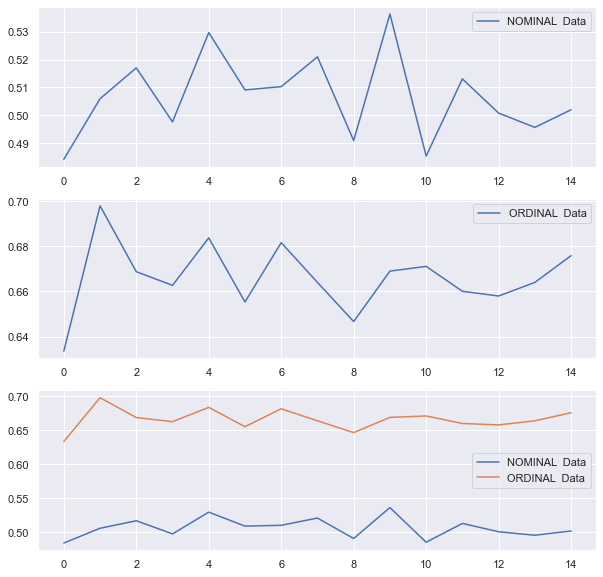

In [49]:
# ohe = OneHotEncoder(min_frequency=0.0001, handle_unknown='infrequent_if_exist', sparse=False,dtype=np.int32)
# X_train_t = ohe.fit_transform(nominal_data)
fig, ax = plt.subplots(3,1,figsize=(10,10))
i = 0
for categories in [nominal, ordinal]:
    X = final_data.loc[:,categories]
    y = final_data.target.to_numpy().reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=10, test_size=0.3)
    feature_names = categories
    model = QuadraticDiscriminantAnalysis(priors=class_priors,store_covariance=True,reg_param=0.0001 )
    # ovr_qda.fit(X_train, y_train)
    # y_pred = QDA_.fit(X_train, y_train)
    cv_= RepeatedStratifiedKFold(n_splits=3,n_repeats=5, random_state=10)
    pipe =  Pipeline(steps=[('polynomialwrapper',
                 PWrapper(feature_encoder=TargetEncoder())),
                ('quadraticdiscriminantanalysis',
                 QuadraticDiscriminantAnalysis(priors=class_priors,
                                               reg_param=0.0001,
                                               store_covariance=True))], memory=mem)
    with parallel_backend('multiprocessing'):
        cv_model = cross_validate(pipe, X, y, cv = cv_,return_train_score=True,n_jobs=-1)
        ax[i].plot(np.arange(15), cv_model['test_score'], label=f'{feature_names[0].split("__")[0].upper()}  Data')
        ax[i].legend()
        ax[2].plot(np.arange(15), cv_model['test_score'], label=f'{feature_names[0].split("__")[0].upper()}  Data')
        ax[2].legend()
    i+=1

In [45]:
pipe = make_pipeline(PWrapper(TargetEncoder()), model)
pipe

Pipeline(steps=[('polynomialwrapper',
                 PolynomialWrapper(feature_encoder=TargetEncoder())),
                ('quadraticdiscriminantanalysis',
                 QuadraticDiscriminantAnalysis(priors=array([[0.32744995, 0.49077977, 0.18177028]]),
                                               reg_param=0.0001,
                                               store_covariance=True))])

In [48]:
Pipeline(steps=[('polynomialwrapper',
                 PWrapper(feature_encoder=TargetEncoder())),
                ('quadraticdiscriminantanalysis',
                 QuadraticDiscriminantAnalysis(priors=class_priors,
                                               reg_param=0.0001,
                                               store_covariance=True))], memory=mem)




Pipeline(memory=Memory(location=../data/joblib_memory/joblib),
         steps=[('polynomialwrapper',
                 PolynomialWrapper(feature_encoder=TargetEncoder())),
                ('quadraticdiscriminantanalysis',
                 QuadraticDiscriminantAnalysis(priors=array([[0.32744995, 0.49077977, 0.18177028]]),
                                               reg_param=0.0001,
                                               store_covariance=True))])